# Práctica 9: Transfer learning


## Pre-requisitos

### Instalar paquetes

Si la práctica requiere algún paquete de Python, habrá que incluir una celda en la que se instalen. Si usamos un paquete que se ha utilizado en prácticas anteriores, podríamos dar por supuesto que está instalado pero no cuesta nada satisfacer todas las dependencias en la propia práctica para reducir las dependencias entre ellas.

### NOTA: En <font color='red'>Google Colab</font> hay que instalar los paquetes EN CADA EJECUCIÓN

In [53]:
# Ejemplo de instalación de tensorflow 2.0
#%tensorflow_version 2.x
# !pip3 install tensorflow  # NECESARIO SOLO SI SE EJECUTA EN LOCAL
import tensorflow as tf

# Hacemos los imports que sean necesarios
import numpy as np
import matplotlib.pyplot as plt

# Transfer learning sobre Stanford Dogs

Lo que queremos hacer es entrenar un clasificador para que catalogue las distintas clases de perros almacenadas en el dataset Stanford Dogs. Para ello, lo primero que tenemos que hacer es cargar el dataset.

In [54]:
import tensorflow_datasets as tfds

(ds_train, ds_test), ds_info = tfds.load(
    'stanford_dogs', split=['train', 'test'], with_info=True, as_supervised=True
)
NUM_CLASSES = ds_info.features['label'].num_classes

## Preprocesado de los datos

Antes de nada, vamos a ver el tamaño que tienen las imágenes de entrada.

In [55]:
# ds_train es un iterable con una tupla (imagen, clase). Vamos a ver la resolución de la imagen
for i, element in enumerate(ds_train.take(5)):
    print(element[0].shape)

(500, 333, 3)
(367, 400, 3)
(500, 375, 3)
(321, 450, 3)
(333, 500, 3)


Como podemos observar, el tamaño de las imágenes es variable y no coincide con el tamaño que esperamos a la entrada de la red. 

Nuestro primer cometido será el modificar las imágenes para que tengan el tamaño fijo 224x224x3.

**<font color='red'>PISTA:</font> puedes usar la función [resize](https://www.tensorflow.org/api_docs/python/tf/image/resize) y la función map, que te permite operar sobre cada elemento de un iterable**

In [56]:
## TODO: completa el código en las partes donde hay un None
ds_train = ds_train.map(lambda image, label: (image, label))
ds_test = ds_test.map(lambda image, label: (image, label))

#### Visualización de los datos
Una vez hecho el preprocesado, ya podemos visualizar las imágenes.

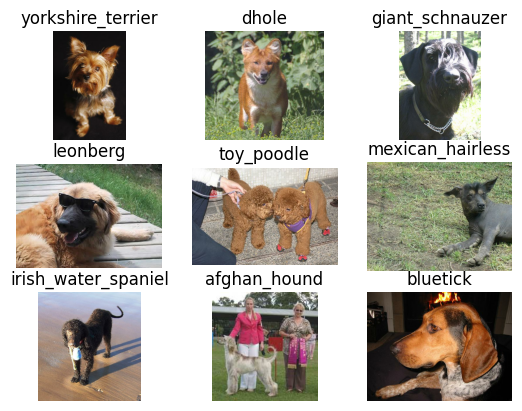

In [57]:
def format_label(label):
    string_label = label_info.int2str(label)
    return string_label.split("-")[1]

label_info = ds_info.features["label"]

for i, (image, label) in enumerate(ds_train.take(9)):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(image.numpy().astype("uint8"))
    plt.title("{}".format(format_label(label)))
    plt.axis("off")

A mayores, cada red preentrenada tiene un preprocesado de los datos propio, que hay que realizar antes de pasárselo al modelo. En el caso de DenseNet121, la función de preprocesado se llama 

```
tf.keras.applications.densenet.preprocess_input
```


In [58]:
## TODO: aplica la función de preprocesado a los conjuntos del dataset

x = tf.keras.applications.densenet.preprocess_input(ds_train)
net = tf.keras.applications.DenseNet121()

AttributeError: '_MapDataset' object has no attribute 'shape'

La etiqueta es numérica, y hay que convertirla a tipo one_hot con la función [tf.one_hot](https://www.tensorflow.org/api_docs/python/tf/one_hot)

**<font color='red'>PISTA:</font> el número de clases se ha almacenado anteriormente en la variable NUM_CLASSES**

In [ ]:
## TODO: convierte las etiquetas a tipo one hot.
ds_test = tf.one_hot(ds_test, NUM_CLASSES)

ValueError: Attempt to convert a value (<_MapDataset element_spec=(TensorSpec(shape=(None, None, 3), dtype=tf.uint8, name=None), TensorSpec(shape=(), dtype=tf.int64, name=None))>) with an unsupported type (<class 'tensorflow.python.data.ops.map_op._MapDataset'>) to a Tensor.

Finalmente, nos queda preparar los datos en batches para pasárselos al entrenamiento. Aquí distinguiremos entre entrenamiento y test, ya que los datos de entrenamiento es mejor hacer los batches de manera aleatoria en cada iteración.

In [ ]:
batch_size = 128
ds_train_batch = ds_train.cache().shuffle(batch_size*5).batch(batch_size)
ds_test_batch = ds_test.batch(batch_size) # En test no es necesario aleatorizar

## Creando el modelo

Una vez obtenido un correcto preprocesado de los datos, vamos a crear el modelo. Nuestro modelo constará de tres partes diferenciadas:

1. Data augmentation
1. DenseNet121 preentrenado
1. Clasificador

Vamos a ir paso a paso creando cada uno de los puntos.

### Data augmentation

El primer paso que vamos a realizar es aumentar los datos de entrenamiento mediante la aplicación de distintas operaciones, que se encuentran en el paquete [tensorflow.keras.layers.experimental.preprocessing](https://www.tensorflow.org/api_docs/python/tf/keras/layers/experimental/preprocessing). En concreto, vamos a realizar las siguientes operaciones:

1. Rotaciones aleatorias de $2*\pi*0.15$ grados
1. Traslaciones aleatorias del $10\%$ del tamaño de la imagen
1. Giros aleatorios de la imagen
1. Cambios aleatorios del contraste del $10\%$

In [ ]:
from tensorflow.keras.layers.experimental import preprocessing
from tensorflow.keras.models import Sequential

## TODO: crea el modelo de data augmentation, rellenando los huecos marcados con None
img_augmentation = Sequential(
    [
        tf.keras.layers.RandomRotation(2 * np.pi() * np.degrees(0.15)), # rotaciones
        tf.keras.layers.RandomTranslation(0.1,0.1), # traslaciones
        tf.keras.layers.RandomFlip(), # giros
        tf.keras.layers.RandomContrast(0.1)  # contraste
    ],
    name="img_augmentation",
)

TypeError: 'float' object is not callable

### Descargar un modelo preentrenado


Lo primero que vamos a hacer es descargar un modelo preentrenado. Por suerte, en Tensorflow tenemos una serie de modelos ya preentrenados. Se encuentran en el paquete **tensorflow.keras.applications** ([Doc](https://keras.io/api/applications/)). En concreto, vamos a utilizar la red DenseNet121, cuyo esquema podemos ver en la siguiente imagen:

<img src="./img/densenet121.png" alt="DenseNet121" width="600"/>

En esencia, es una variante del bloque residual, en donde la salida de una capa se suma a todas las salidas de las capas siguientes.

Para cargar el modelo haremos lo siguiente:

In [ ]:
from tensorflow.keras.applications import DenseNet121

# Cargamos el modelo. 
densenet = DenseNet121(
    weights='imagenet', # El parámetro weights le dice que cargue los datos de la red ya entrenada sobre el dataset ImageNet
    include_top=False, # El parámetro include_top le dice que cargue la última capa con el clasificador
    input_shape=(224, 224, 3), # Este parámetro será necesario para hacer transfer learning, 
                      # pues necesitaremos especificar el tamaño de los datos de entrada
)

# Comprobamos el tamaño de entrada de la red
print('Input shape :', densenet.input_shape)

# Comprobamos el tamaño de salida de la red
print('Output shape :', densenet.output_shape)



En la [documentación](https://keras.io/api/applications/densenet/#densenet121-function) dodemos ver que esta red admite, como entrada, imágenes de tamaño 224x224x3. Aunque podemos utilizar cualquier tamaño de entrada (siempre que sea mayor de 32x32x3), vamos a seguir utilizando ese tamaño.

### Crear el clasificador

Para crear el clasificador, lo que vamos a hacer es crear una última capa que será un clasificador lineal (capa [Dense](https://www.tensorflow.org/api_docs/python/tf/keras/layers/Dense)). Sin embargo, podemos observar que la salida de la red DenseNet tiene 4 dimensiones, no 2 que es lo necesario para crear el clasificador. Aquí tenemos dos opciones para realizar la conversión:

1. Usar [Flatten](https://www.tensorflow.org/api_docs/python/tf/keras/layers/Flatten), en la que la dimensión 2 será de tamaño la multiplicación de las dimensiones 2, 3 y 4.
1. Usar GlobalPooling, colapsando las dimensiones 2 y 3, siendo por tanto la dimensión 2 de salida igual a la dimensión 4 de entrada.

Aquí podemos ver una imagen ilustrando la diferencia:

<img src="./img/flatten_vs_gap.png" alt="Flatten vs Global Pooling" width="800"/>

En nuestro caso, vamos a usar un GlobalPooling, en concreto [GlobalAveragePooling2D](https://www.tensorflow.org/api_docs/python/tf/keras/layers/GlobalAveragePooling2D). A mayores, añadiremos alguna regularización extra como [Dropout](https://www.tensorflow.org/api_docs/python/tf/keras/layers/Dropout) o [Batch Normalization](https://www.tensorflow.org/api_docs/python/tf/keras/layers/BatchNormalization).

In [ ]:
from tensorflow.keras import layers

## TODO: crea el clasificador, rellenando los huecos marcados por None
classifier = Sequential(
    [
        tf.keras.layers.GlobalAveragePooling2D()(ds_train), # GlobalAveragePooling2D
        tf.keras.layers.BatchNormalization(), # BatchNormalization
        tf.keras.layers.DropOut(0.2), # Dropout con probabilidad 0.2
        tf.keras.layers.Dense(ds_train.shape()), # Dense con salida el número de clases del dataset
        tf.keras.layers.Dense(activation="softmax") # Softmax activation
    ]
)

ValueError: Only input tensors may be passed as positional arguments. The following argument value should be passed as a keyword argument: <_MapDataset element_spec=(TensorSpec(shape=(None, None, 3), dtype=tf.uint8, name=None), TensorSpec(shape=(), dtype=tf.int64, name=None))> (of type <class 'tensorflow.python.data.ops.map_op._MapDataset'>)

### Combinando todos los elementos

Una vez creados todos los elementos, sólo nos falta combinarlos. Hay que recordar que la red preentrenada no se modifica, por lo que hay que indicarle que los pesos no son entrenables.

In [ ]:
## TODO: Crea el modelo final combinando los 3 modelos creados anteriormente

input = None  # capa de input, teniendo en cuenta el tamaño de las imágenes 

input_augmented = None  # aplica el modelo de data augmentation a la capa de entrada

densenet.trainable = False
densenet_output = None  # aplica el modelo densenet

output = None  # aplica el clasificador

model = tf.keras.Model(None, None, name="DenseNet")  # crea el modelo final, indicando la entrada y la salida
optimizer = None  # define el optimizador. Usaremos un Adam
model.compile(
    optimizer=None, loss=None, metrics=[None]  # Compila el modelo, usando el optimizador creado, la función de pérdida para clasificación multiclase y la métrica de precisión
)

## Entrenando el modelo

Por último, sólo nos queda entrenar el modelo durante 10 iteraciones (ten paciencia, puede llevar sobre 10 minutos). En test, deberíamos tener una precisión cercana al $80\%$.

In [ ]:
hist = model.fit(
    ds_train_batch, epochs=10, verbose=1  # se podría poner validation_data=ds_test_batch, y así ver en cada iteración como va, pero en este caso consume mucho tiempo
)


def plot_hist(hist):
    plt.plot(hist.history["accuracy"])
    # plt.plot(hist.history["val_accuracy"])
    plt.title("train accuracy")
    plt.ylabel("accuracy")
    plt.xlabel("epoch")
    # plt.legend(["train", "validation"], loc="upper left")
    plt.show()

print('TEST ACCURACY : ', model.evaluate(ds_test_batch)[-1])

plot_hist(hist)

## Fine tunning

Al inicio hemos entrenado el modelo sin tocar los pesos de la red DenseNet. Sin embargo, ahora que ya hemos entrenado las capas finales, podemos reentrenar el modelo al completo. Sin embargo, hay que tener en cuenta una serie de consideraciones.

- La tasa de aprendizaje tiene que ser muy baja. Un valor alto podría eliminar la calidad del entrenamiento inicial, haciendo que el sistema se comporte de manera similar a entrenarlo desde 0.
- Las capas de Batch Normalization se mantienen sin entrenar. Esto es debido a que dificultan el entrenamiento en redes ya entrenadas, y sólo estamos buscando un ajuste fino en el sistema.

In [ ]:
## TODO: completa aquellos puntos marcados con None
batch_size = 32 # Tenemos que bajar el tamaño anterior para no saturar la memoria del sistema
ds_train_batch = ds_train.cache().shuffle(batch_size*5).batch(batch_size)
ds_test_batch = ds_test.batch(batch_size)

def unfreeze_model(model):
    # Descongelamos las últimas 20 capas while, dejando BatchNormalization sin entrenar
    for layer in model.layers[-20:]:
        if not isinstance(layer, None): # Comprueba que la capa no sea de tipo BatchNormalization
            None                        # Marca la capa como entrenable

    optimizer = None                    # Usa Adam con una tasa de aprendizaje de 1e-5
    model.compile(
        None, None, None                # define el compilador, la función de coste y la métrica
    )

None                                    # Llama a la función que has creado sobre nuestro modelo

epochs = 8  
hist = None  # Llama a la función de entrenamiento sobre el modelo

plot_hist(hist)

print('TEST ACCURACY : ', model.evaluate(ds_test_batch)[-1])

La precisión en entrenamiento ha subido, pero en test ha bajado. ¿Qué puede estar pasando?

# ¡ENHORABUENA! Has completado la práctica de Transfer Learning.

# ¿Deseas saber más?

El transfer learning no se limita sólo a entrenar las últimas capas. Se pueden utilizar sólo unas pocas capas preentrenadas, y entrenar el resto. No hay límite sobre lo que se puede hacer. Tampoco se restringe a clasificación únicamente. Las *deep features* de un modelo de clasificación suelen ser útiles para modelos de regresión, segmentación, etc.

# Trabajo extra

Como trabajo extra, se propone realizar una idea parecida, pero con dificultad añadida.

- El dataset a utilizar será [cifar10](https://www.tensorflow.org/datasets/catalog/cifar10).
- Se utilizará una entrada de la red de 32x32x3.
- La red preentrenada a utilizar será [MobileNetV3Small](https://www.tensorflow.org/api_docs/python/tf/keras/applications/MobileNetV3Small).
- Puedes escoger el calsificador que quieras.

In [ ]:
# TODO: escribe el código para el trabajo extra sin ayuda. Usa todos los bloques de código que quieras.